In [77]:
import pylab
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, interpolate

# importation de module pour la manipulation de fichiers audios
from fastdtw import fastdtw, dtw
from pydub import AudioSegment
from scipy.io.wavfile import read as wread
from scipy.spatial.distance import euclidean

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


In [78]:
def _datacheck_peakdetect(x_axis, y_axis):
    if x_axis is None:
        x_axis = range(len(y_axis))
    
    if len(y_axis) != len(x_axis):
        raise ValueError( 
                "Input vectors y_axis and x_axis must have same length")
    
    #needs to be a numpy array
    y_axis = np.array(y_axis)
    x_axis = np.array(x_axis)
    return x_axis, y_axis


def peakdetect(y_axis, x_axis = None, lookahead = 200, delta=0):
    """
    Converted from/based on a MATLAB script at: 
    http://billauer.co.il/peakdet.html
    
    function for detecting local maxima and minima in a signal.
    Discovers peaks by searching for values which are surrounded by lower
    or larger values for maxima and minima respectively
    
    keyword arguments:
    y_axis -- A list containing the signal over which to find peaks
    
    x_axis -- A x-axis whose values correspond to the y_axis list and is used
        in the return to specify the position of the peaks. If omitted an
        index of the y_axis is used.
        (default: None)
    
    lookahead -- distance to look ahead from a peak candidate to determine if
        it is the actual peak
        (default: 200) 
        '(samples / period) / f' where '4 >= f >= 1.25' might be a good value
    
    delta -- this specifies a minimum difference between a peak and
        the following points, before a peak may be considered a peak. Useful
        to hinder the function from picking up false peaks towards to end of
        the signal. To work well delta should be set to delta >= RMSnoise * 5.
        (default: 0)
            When omitted delta function causes a 20% decrease in speed.
            When used Correctly it can double the speed of the function
    
    
    return: two lists [max_peaks, min_peaks] containing the positive and
        negative peaks respectively. Each cell of the lists contains a tuple
        of: (position, peak_value) 
        to get the average peak value do: np.mean(max_peaks, 0)[1] on the
        results to unpack one of the lists into x, y coordinates do: 
        x, y = zip(*max_peaks)
    """
    max_peaks = []
    min_peaks = []
    dump = []   #Used to pop the first hit which almost always is false
       
    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    # store data length for later use
    length = len(y_axis)
    
    
    #perform some checks
    if lookahead < 1:
        raise ValueError("Lookahead must be '1' or above in value")
    if not (np.isscalar(delta) and delta >= 0):
        raise ValueError("delta must be a positive number")
    
    #maxima and minima candidates are temporarily stored in
    #mx and mn respectively
    mn, mx = np.Inf, -np.Inf
    
    #Only detect peak if there is 'lookahead' amount of points after it
    for index, (x, y) in enumerate(zip(x_axis[:-lookahead], 
                                        y_axis[:-lookahead])):
        if y > mx:
            mx = y
            mxpos = x
        if y < mn:
            mn = y
            mnpos = x
        
        ####look for max####
        if y < mx-delta and mx != np.Inf:
            #Maxima peak candidate found
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].max() < mx:
                max_peaks.append([mxpos, mx])
                dump.append(True)
                #set algorithm to only find minima now
                mx = np.Inf
                mn = np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
                continue
            #else:  #slows shit down this does
            #    mx = ahead
            #    mxpos = x_axis[np.where(y_axis[index:index+lookahead]==mx)]
        
        ####look for min####
        if y > mn+delta and mn != -np.Inf:
            #Minima peak candidate found 
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].min() > mn:
                min_peaks.append([mnpos, mn])
                dump.append(False)
                #set algorithm to only find maxima now
                mn = -np.Inf
                mx = -np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
            #else:  #slows shit down this does
            #    mn = ahead
            #    mnpos = x_axis[np.where(y_axis[index:index+lookahead]==mn)]
    
    
    #Remove the false hit on the first value of the y_axis
#     try:
#         if dump[0]:
#             max_peaks.pop(0)
#         else:
#             min_peaks.pop(0)
#         del dump
#     except IndexError:
#         #no peaks were found, should the function return empty lists?
#         pass
        
    return [max_peaks, min_peaks]

In [135]:



def w_k(k, n, N):
    return np.exp(2*1j*k*n*np.pi/N)

def dft(s, N):
    result = [0]*int(N)
    k = 0
    while (k<N):
        n=0
        while (n<N):
            result[k] += s[n]*w_k(k,n,N).conjugate()
            n = n + 1
        k = k + 1
    return result


# Fichier en entrée (ce qui a été dit)

f_echant, data = wread('sound/1.wav')
facteur = 16

# representation amplitude fréquence
abscisse = []
ordonne = []
cpt = 0

def hammi(signal):
    # découpage en fenetres de hamming, 22050 fps, pour 20ms la fenetre ça fait 22050*0.020
    nTailleFen = round(22050*0.01) #10 ms
    fenPure = np.hamming(nTailleFen)
    nSize = len(signal)
    tSortie = []
#     print(fenPure[:50])
#     print( signal)
#     print(nSize)
#     print(nTailleFen)
#     print(nSize//nTailleFen)
#     n = 20
#     tSortie.append( signal[n*nTailleFen:(n+1)*nTailleFen]*fenPure )
#     print( tSortie)
    n=0
    nDecal = (nTailleFen+1)//2
#     nDecal = nTailleFen
    while (n*nDecal) < (nSize-nTailleFen):
#     for n in range (nSize):
        tSortie.append( signal[n*nDecal:n*nDecal +nTailleFen]*fenPure )
        n +=1
    
    #padding de 0 en sortie, 5? fois la longueur initiale, pour plus de précision sur la fft/dft
#     for _ in range()
    
    return tSortie
    
# Protocole à suivre :
#     récupération du signal
#     découpage en trames/fenetres de hamming
#     application de la fft sur chaque trame pour avoir le spectre
#     récupération des paramètres/caractéristiques du spectre par la mfcc
#     on obtient alors le cepstre
#     application du liftrage pour enlever le bruit/récupérer que ce qui nous intéresse
    
#     Comparaison ici des résultats avec dft appliquée sur de petites fenêtres au cas où le signal est distordu ?
    
#     Optimisation par détection des silences pour ne pas en prendre compte ?


# np.fft()
# np.dft()
# np.dft_signal_ss_echant()



# normalement on applique la DFT sur tout le signal donc avec N=len(s)
# cependant avec cette méthode de calcul non optimisée, c'est trop lent
# il faut sous-echantilloner, par exemple d'un facteur 4

# print ("Nombre d'echantillons du signal sous-echantillone d'un facteur ", facteur, " : ", len(data)/facteur)
# taille de la transformée de Fourier
# N = int(len(data) / facteur)  # on prend une valeur paire pour N
# if (N%2!=0):
#     N = N -1
# print ("Taille de la DFT : ",N)
# Nouvelle fréquence d'échantillonage
# NFS = f_echant / facteur
# print ("Nouvelle Frequence d'echantillonage : ", NFS )
# nouvelle resolution fréquentielle
# = une des valeurs de la DFT représente (englobe) combien de Hz
# RF = NFS / N
# print ("Resolution frequentielle: ", RF)

# on calcul la DFT du signal sous-echantillone
# dft_signal_ss_echant=dft(data[::facteur],len(data)//facteur)

# on affiche le spectre d'amplitude, que sur la moitié à cause de la symétrie fréquentielle
# on passe les amplitudes en dB
# cpt = 0
# abscisse = []
# ordonne = []
# while (cpt<N):
#         abscisse.append(RF * cpt)
#         ordonne.append(10 * np.log10(abs(dft_signal_ss_echant[cpt])))
        # cpt += 1

# A revoir
def detection_parole(son):
    facteur = 16
    N = int(len(son) / facteur)  # on prend une valeur paire pour N
    if (N % 2 != 0):
        N = N - 1
    dft_signal_ss_echant = dft(son[::facteur], len(son) // facteur)
    log_result = []
    moyenne_log = 0
    for elem in dft_signal_ss_echant:
        log_result.append(10 * np.log10(abs(elem)))
        moyenne_log += 10 * np.log10(abs(elem))
    max_log = max(log_result)
    moyenne_log = moyenne_log / len(dft_signal_ss_echant)

    print("Max log:")
    print(max_log)

    print(moyenne_log)
    # 10% de variation -> parole
    if ((max_log-moyenne_log) > moyenne_log*0.1):
        print("Bruit détecté \n")
    else:
        print("RAS mon colonel \n")


def comparaison(son):
    f_echant, data = wread('audiorecordtest2TMP.wav')
    # f_echant2, data2 = wread('sound/1.wav')

    # 36 pour les 10 chiffres et les 26 lettres
    distance = [100]*36
    # Comparaison avec les chiffres
    cpt = 0
    print(len(data))
    while (cpt<10):
        nomFichier = 'sound/' + str(cpt) +'.wav'
        print(nomFichier)
        f_echant2, data2 = wread(nomFichier)
        print(len(data2))
        distance[cpt], _ = fastdtw(data, data2, dist=euclidean)
#         distance[cpt], _ = dtw(data, data2, dist=euclidean)
        print(cpt)
        cpt = cpt + 1
    # facteur = 16
    # N = int(len(son) / facteur)  # on prend une valeur paire pour N
    # if (N % 2 != 0):
    #     N = N - 1
    # NFS = f_echant / facteur
    # RF = NFS / N
    # dft_signal_ss_echant = dft(data[::facteur], len(data) // facteur)
    # dft_signal_ss_echant2 = dft(data2[::facteur], len(data2) // facteur)
    # distance, path = fastdtw(data, data2, dist=euclidean)
    print(distance)

def Affichages(sFichier, data, dataModded, tZRC, tZREnergie, tSignalHamminged, tSignalFft, \
               bSignalOrignal = True, bHamminged=True, bZRs=True, bFftFused=True, bFFTs=True, bPeaks=True):
    # print(tZRC3[::100])
    if (bSignalOrignal):
        plt.plot(data)
    if (bZRs):
        # plus la fenetre est courte et plus la courbre est agitée
        plt.plot(tZRC)
        plt.plot(tZREnergie)
    if (bSignalOrignal or bZRs):
        plt.title("Fichier "+str(sFichier))
        plt.show()
    
    if (bHamminged):
        nDecalage = (len(tSignalHamminged[0])+1)//2
        # [x * 221 for x in  list(range(0,len(tSignalHamminged)) ) ]
        # plt.plot([item for sublist in tSignalHamminged for item in sublist] )
        plt.plot([x * nDecalage for x in  list(range(0,len(tSignalHamminged)) ) ], tSignalHamminged)
        plt.title("fenêtré hamming")
        plt.show()

    if (bFftFused):
        plt.plot([x * nDecalage for x in  list(range(0,len(tSignalFft)) ) ], tSignalFft)
        # plt.plot([item for sublist in tSignalFft for item in sublist] )
        plt.title("fft")
        plt.show()

    if (bFFTs):
        # plot sur chaque fft, fréquence en abscices db sans log sur ordonnée
        for x in range (len(tSignalFft)):
            plt.plot(tSignalFft[x])
            plt.title("Fenêtre : "+ str(x))
            #ligne = signal.find_peaks_cwt(tSignalFft[x],np.arange(1,6),max_distances=[50,50,50,50,50], noise_perc=5, gap_thresh=25 )
            ligne = peakdetect(tSignalFft[x], lookahead=30, delta=800)
            #findpeaks()
            vals = []
            #print(ligne)
#             for xi in range(len(ligne)):
#                 vals.append( tSignalFft[x][ligne[xi]] )
#             print(vals)
#             plt.plot(ligne, vals )
            if (bPeaks):
                plt.plot([ item[0] for item in ligne[0]], [ item[1] for item in ligne[0]])
            plt.show()

    

def HammingPaddingFourier(dataModded):
    tSignalHamminged = hammi(dataModded)
    # print(tSignalHamminged)
    tSignalFft = tSignalHamminged[:]
    
    #padding de 0 en sortie, 5? fois la longueur initiale, pour plus de précision sur la fft/dft
    tPaddTableau = np.array([0] * len(tSignalFft[0]) *5)
    # print(tSignalFft[10])
    for x in range(len(tSignalFft)):
        tSignalFft[x] = np.concatenate((tSignalFft[x],tPaddTableau))
    # print(tSignalFft[10])    

    tSignalFft = list(map(np.fft.fft, tSignalFft) )
    Reel = lambda x: x.real
    Image = lambda x: x.imag
    Module = lambda x: abs(x)
    tSignalFft = list(map(Module, tSignalFft) )
    return (tSignalHamminged, tSignalFft)
    
def detectVoix(data): #vad voice active detection
    dataModded = data[:]
    tSignalHamminged = hammi(data)
    #ZRC zero crossing rate, pour elimination des silences
    tnbZeros = []
    cpt = 1
    while cpt<len(data):
        if (data[cpt]>0 and data[cpt-1]>0):
            tnbZeros.append(0)
        elif (data[cpt]<0 and data[cpt-1]<0):
            tnbZeros.append(0)
        else:
            tnbZeros.append(1)
        cpt +=1

    cpt = 0
    tZRC2 = []
    tZRC3 = []
    tEnergie = []
    tSignalHamminged
    
    nHam = len(tSignalHamminged[0])
    nDecalage = (nHam+1)//2
    
    for indice, item in enumerate(tSignalHamminged):
        nMoyEnergie = 0
        for x in range(nHam):
            nMoyEnergie += (data[x+indice*nDecalage]/nHam)**2
        tEnergie.append(nMoyEnergie)
    
    nMax = nDecalage*len(tSignalHamminged)
#     print(nHam)
#     print(nDecalage)
#     print(nMax+nDecalage)
    tAbs = np.arange(0,nMax+3*nDecalage,nDecalage)
#     print(tEnergie)
#     print (len(data))
#     print( tAbs )
    f = interpolate.interp1d(tAbs, [tEnergie[0]]+tEnergie+[tEnergie[-1],tEnergie[-1]])
    
    
    cpt=0
    while cpt<len(tnbZeros) :
        
        nMin = max(cpt-250,0)
        nMax = min(cpt+250,len(tnbZeros))
        nLong = nMax-nMin
        
        ajout = (sum(tnbZeros[nMin:nMax])/nLong)* 50000 
        tZRC2.append(ajout)
        nEnergieEtZeroRate = f(cpt)*ajout*0.00002
#         if (ajout >20000): # 3600):
        if (nEnergieEtZeroRate <30):
            ajout = 0
            dataModded[cpt] = 0
        else:
            ajout = nEnergieEtZeroRate+5000
        tZRC3.append( ajout)
        cpt +=1
    
#     tmp = [a*b*0.00002 for a,b in zip(f(np.arange(len(data))),tZRC2)] 
#     tZRC3 = []
#     for item in tmp:
#         if (item<30):
#             item = 0
#         else:
#             item +=5000
#         tZRC3.append(item)
#     print(tZRC3[2000:2050])
#     tZRC3 = np.log10(tZRC3)
#     print("log\n", tZRC3[2000:2050], "\n\n")
#     tZRC3 = f(np.arange(len(data)))
    
    return (dataModded, tZRC2, tZRC3)

def travail(tFichiers):
    for sFichier in tFichiers:
        f_echant, data = wread(sFichier)    
        dataModded, tZRC, tZREnergie = detectVoix(data)
        #Hamming, padding zeros, fft
        tSignalHamminged, tSignalFft = HammingPaddingFourier(dataModded)
        Affichages(sFichier, data, dataModded, tZRC, tZREnergie, tSignalHamminged, tSignalFft, bFFTs=False)
        

    


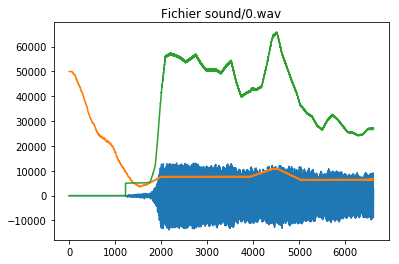

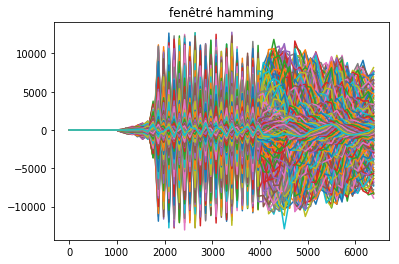

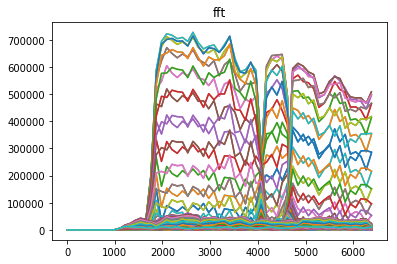

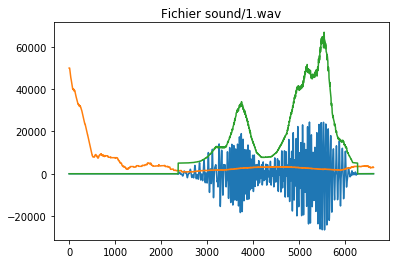

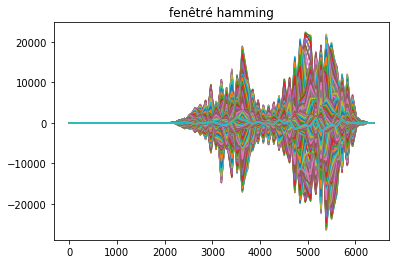

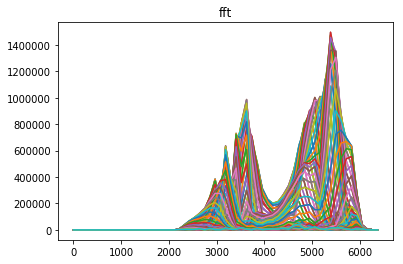

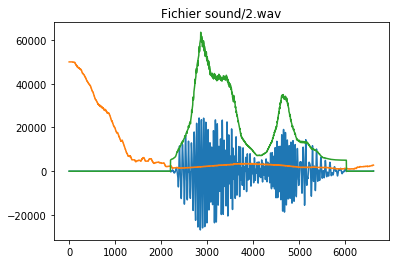

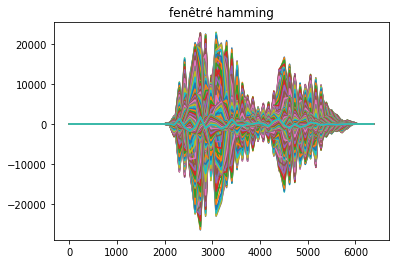

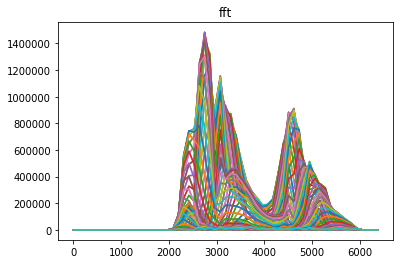

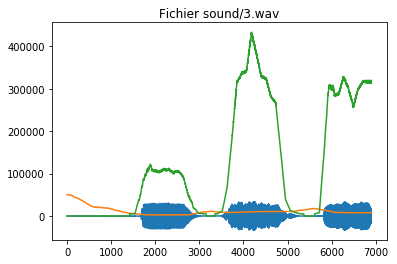

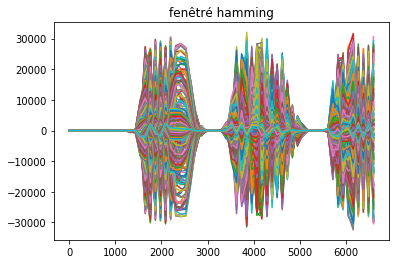

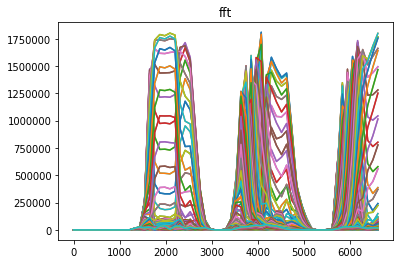

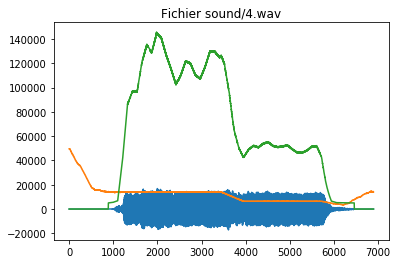

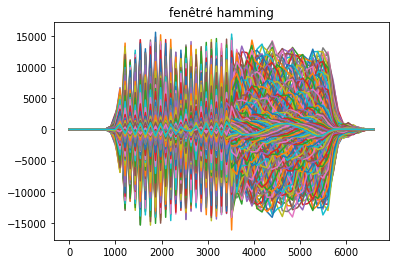

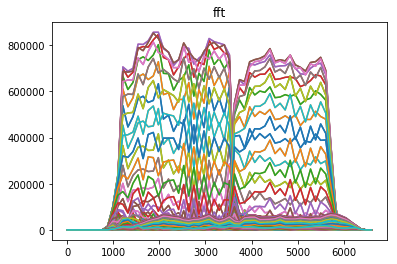

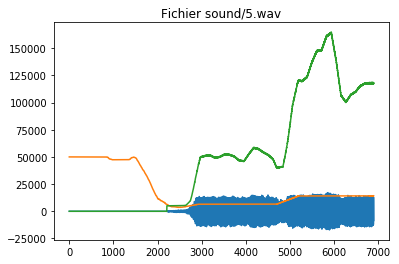

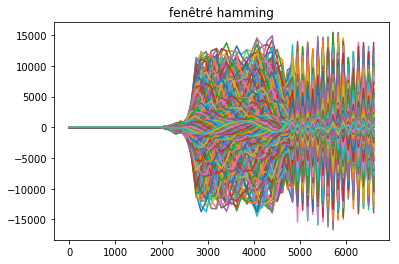

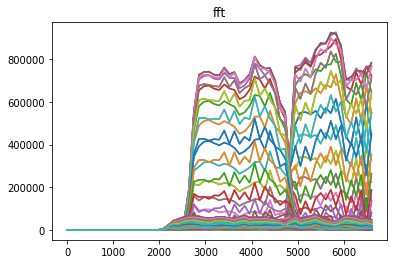

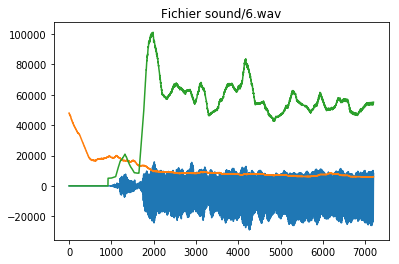

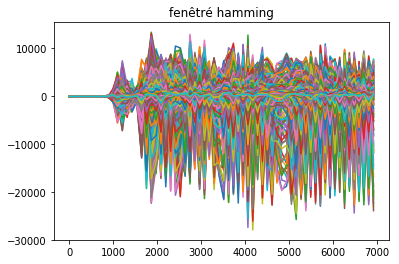

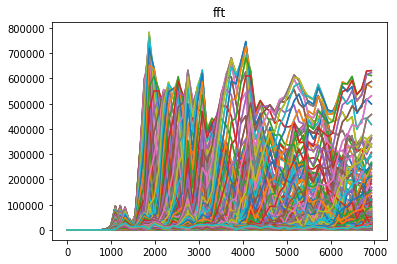

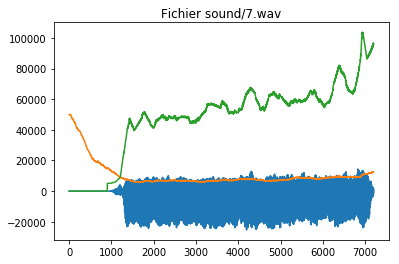

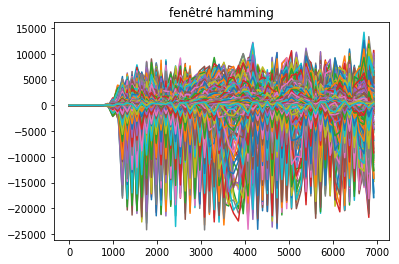

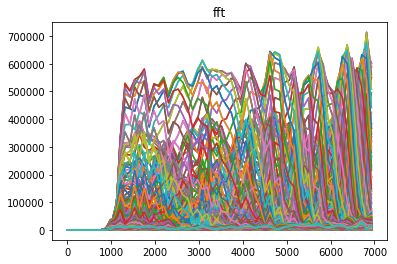

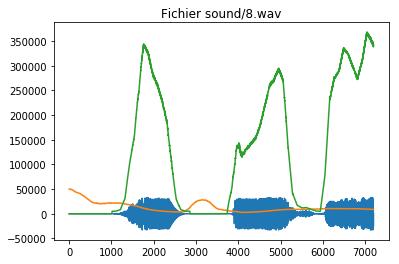

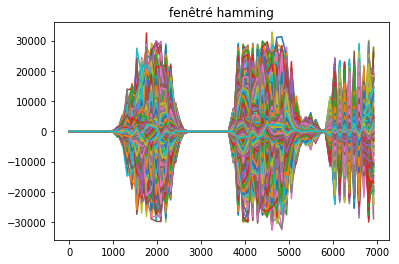

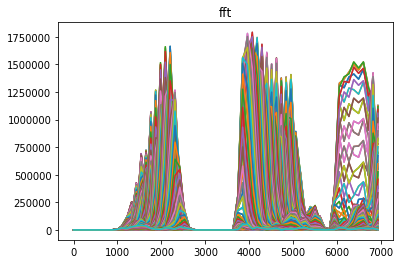

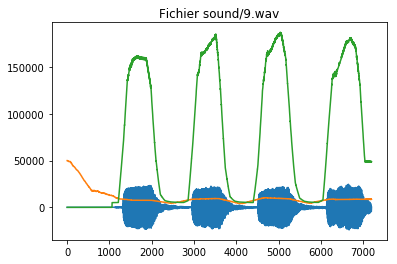

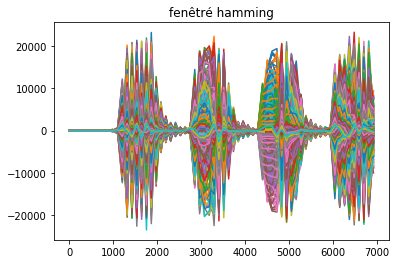

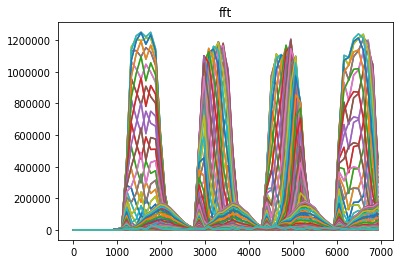

In [136]:

    
# travail(['sound/0.wav'])

travail(['sound/0.wav','sound/1.wav','sound/2.wav','sound/3.wav'])
travail(['sound/4.wav','sound/5.wav','sound/6.wav','sound/7.wav','sound/8.wav','sound/9.wav'])




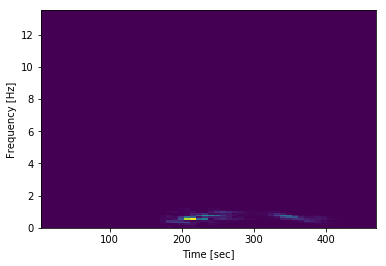

In [86]:
###### test, ça marche pas comme ça, spectrogram de signal veut une fft pas une successions de fenêtres recouvrantes



f, t, Sxx = signal.spectrogram(np.array([item for sublist in tSignalHamminged for item in sublist]), 27)
# f, t, Sxx = signal.spectrogram(np.array([item for sublist in tSignalFft for item in sublist]), 144)
# f, t, Sxx = signal.spectrogram(np.array(tSignalFft[94]))
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()